In [24]:
# Dependencies
import config
import tweepy
import numpy as np
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [15]:
# Twitter accounts that we are going to analyze
target_user = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes")

# Create an empty list for dictionaries of sentiment results
results_list = []

# List for holding sentiments
sentiments = []


In [16]:
#Loop through each target user

for user in target_user:
    
    #Initialize empty lists to hold the sentiment results
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
        
    #Initialize the counter variable
    counter = 1
    
    # Variable for max_id
    oldest_tweet = None
    
     # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(1, 6):

        # Get all tweets from home feed using Tweepy
        public_tweets = api.user_timeline(user, max_id = oldest_tweet)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweet_date = tweet["created_at"]
            
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1
        

            # Add each value to the appropriate list
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
           
                  
            #Add sentiments for each tweet into a list
            sentiments.append({"Username": user,
                               "Date": tweet_date, 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})
    
            #Add to counter 
            counter += 1
  
print(f"Finished getting results from Twitter.")
    
    

Finished getting results from Twitter.


In [53]:
# Create DataFrame from Results List
results_df = pd.DataFrame.from_dict(sentiments).set_index("Username").round(3)
results_df.head(10)

,Compound,Date,Negative,Neutral,Positive,Tweets Ago
Username,,,,,,
@BBC,0.475,Sun Sep 30 20:21:03 +0000 2018,0.843,0.000,0.157,1
@BBC,0.624,Sun Sep 30 19:39:53 +0000 2018,0.687,0.000,0.313,2
@BBC,0.000,Sun Sep 30 19:03:02 +0000 2018,1.000,0.000,0.000,3
@BBC,0.000,Sun Sep 30 17:16:03 +0000 2018,1.000,0.000,0.000,4
@BBC,0.511,Sun Sep 30 16:22:42 +0000 2018,0.769,0.063,0.167,5
@BBC,0.457,Sun Sep 30 16:22:25 +0000 2018,0.875,0.000,0.125,6
@BBC,0.000,Sun Sep 30 16:01:09 +0000 2018,0.773,0.113,0.113,7
@BBC,0.000,Sun Sep 30 15:03:03 +0000 2018,1.000,0.000,0.000,8
@BBC,-0.296,Sun Sep 30 14:02:04 +0000 2018,0.901,0.099,0.000,9


In [67]:
#Function for plotting the Twitter sentiment results
def sentiment_plot(username):
    
    x_vals = results_df.loc[username, "Tweets Ago"]
    y_vals = results_df.loc[username, "Compound"]
    plt.plot(x_vals,
             y_vals, marker="o", linewidth=0.5,
             alpha=0.8)

    # # Incorporate the other graph properties
    now = datetime.datetime.now()
    now = now.strftime("%m-%d-%y %H:%M")
    plt.title(f"Sentiment Analysis of Tweets As Of {now}")
    plt.ylim([-1.0,1.0]) 
    plt.xlim([100, 0])
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    plt.legend({username}, title="Tweets", bbox_to_anchor=(1.30, 1), shadow=True)
    plt.show()

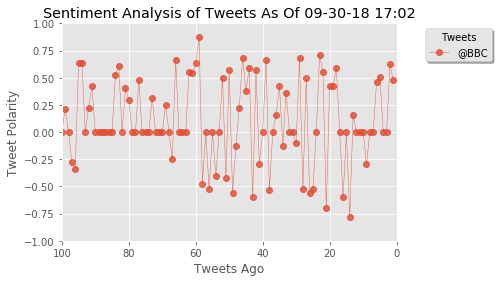

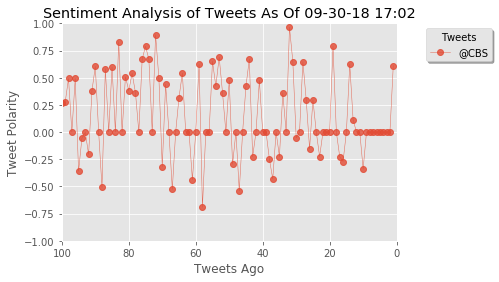

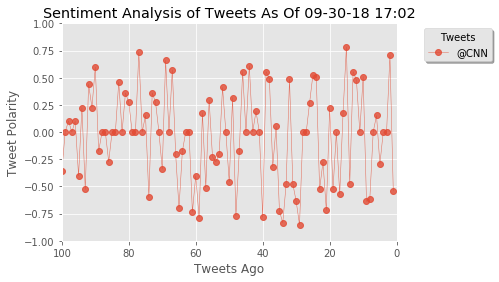

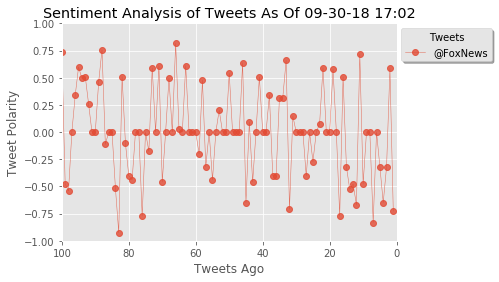

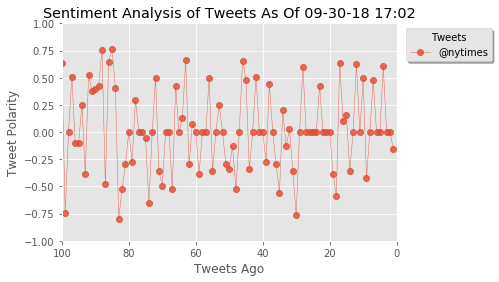

In [68]:
#Call the sentiment plotting function for each news organization

for name in target_user:
    sentiment_plot(name)



In [ ]:
#data for the plot of the aggregate
user_results = {
        "Username": user,
        "Tweets Ago": counter,
        "Date": tweet["created_at"]
        "Compound Score": np.mean(compound_list),
        "Postive Score": np.mean(positive_list),
        "Neutral Score": np.mean(neutral_list),
        "Negative Score": np.mean(negative_list)
    }
